In [1]:
# AQI Islamabad — EDA Notebook (Hopsworks Feature Store)

# This notebook loads `aqi_features_v2` from Hopsworks, performs EDA,
# creates trend plots, feature engineering preview, and saves outputs.
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
import hopsworks

# Load .env from project root
load_dotenv()

# If you already have config.py, prefer that:
try:
    from config import FEATURE_GROUP_NAME, FEATURE_GROUP_VERSION, HOPSWORKS_PROJECT, HOPSWORKS_API_KEY, HOPSWORKS_HOST
except Exception:
    FEATURE_GROUP_NAME = os.getenv("FEATURE_GROUP_NAME", "aqi_features_v2")
    FEATURE_GROUP_VERSION = int(os.getenv("FEATURE_GROUP_VERSION", "1"))
    HOPSWORKS_PROJECT = os.getenv("HOPSWORKS_PROJECT")
    HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
    HOPSWORKS_HOST = os.getenv("HOPSWORKS_HOST")

OUT = Path("outputs")
OUT.mkdir(exist_ok=True)

print("✅ FEATURE_GROUP:", FEATURE_GROUP_NAME, "v", FEATURE_GROUP_VERSION)


c:\Users\thahe\aqi-islamabad-forecast\aqi-islamabad-forecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ FEATURE_GROUP: aqi_features_v2 v 1


In [2]:
if not HOPSWORKS_PROJECT or not HOPSWORKS_API_KEY or not HOPSWORKS_HOST:
    raise ValueError("❌ Missing HOPSWORKS_PROJECT / HOPSWORKS_API_KEY / HOPSWORKS_HOST in .env")

project = hopsworks.login(
    project=HOPSWORKS_PROJECT,
    api_key_value=HOPSWORKS_API_KEY,
    host=HOPSWORKS_HOST,
)

fs = project.get_feature_store()
print("✅ Logged in + Feature Store loaded")


2026-02-11 22:38:08,067 INFO: Initializing external client
2026-02-11 22:38:08,070 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-02-11 22:38:11,443 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3237
✅ Logged in + Feature Store loaded


In [3]:
fg = fs.get_feature_group(FEATURE_GROUP_NAME, version=FEATURE_GROUP_VERSION)

try:
    df = fg.read()   # normal
except Exception as e:
    # FQS fallback (non-hive)
    df = fg.select_all().read()

print("✅ Data shape:", df.shape)
print("✅ Columns:", list(df.columns))
df.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.36s) 
✅ Data shape: (4023, 12)
✅ Columns: ['timestamp_utc', 'event_time', 'city', 'hour', 'day', 'month', 'day_of_week', 'temp_c', 'humidity', 'pressure', 'wind_speed', 'aqi']


,timestamp_utc,event_time,city,hour,day,month,day_of_week,temp_c,humidity,pressure,wind_speed,aqi
0,2026-01-29 19:00:00+00:00,2026-01-29T19:00:00Z,Islamabad,19,29,1,3,12.12,68.0,1021.0,0.89,185.00
1,2025-07-30 23:00:00+00:00,2025-07-30T23:00:00Z,Islamabad,23,30,7,2,23.40,95.0,1001.7,10.80,57.10
2,2025-08-06 06:00:00+00:00,2025-08-06T06:00:00Z,Islamabad,6,6,8,2,29.00,70.0,1004.4,1.80,59.20
3,2025-08-19 14:00:00+00:00,2025-08-19T14:00:00Z,Islamabad,14,19,8,1,26.30,85.0,1002.7,4.90,86.54
4,2025-08-16 23:00:00+00:00,2025-08-16T23:00:00Z,Islamabad,23,16,8,5,23.60,95.0,1004.3,10.20,141.63


In [4]:
fg = fs.get_feature_group(FEATURE_GROUP_NAME, version=FEATURE_GROUP_VERSION)

try:
    df = fg.read()   # normal
except Exception as e:
    # FQS fallback (non-hive)
    df = fg.select_all().read()

print("✅ Data shape:", df.shape)
print("✅ Columns:", list(df.columns))
df.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.42s) 
✅ Data shape: (4023, 12)
✅ Columns: ['timestamp_utc', 'event_time', 'city', 'hour', 'day', 'month', 'day_of_week', 'temp_c', 'humidity', 'pressure', 'wind_speed', 'aqi']


,timestamp_utc,event_time,city,hour,day,month,day_of_week,temp_c,humidity,pressure,wind_speed,aqi
0,2026-01-29 19:00:00+00:00,2026-01-29T19:00:00Z,Islamabad,19,29,1,3,12.12,68.0,1021.0,0.89,185.00
1,2025-07-30 23:00:00+00:00,2025-07-30T23:00:00Z,Islamabad,23,30,7,2,23.40,95.0,1001.7,10.80,57.10
2,2025-08-06 06:00:00+00:00,2025-08-06T06:00:00Z,Islamabad,6,6,8,2,29.00,70.0,1004.4,1.80,59.20
3,2025-08-19 14:00:00+00:00,2025-08-19T14:00:00Z,Islamabad,14,19,8,1,26.30,85.0,1002.7,4.90,86.54
4,2025-08-16 23:00:00+00:00,2025-08-16T23:00:00Z,Islamabad,23,16,8,5,23.60,95.0,1004.3,10.20,141.63


In [5]:
df = df.copy()
df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], utc=True, errors="coerce")
df = df.dropna(subset=["timestamp_utc"]).sort_values("timestamp_utc")

print("✅ Timestamp min:", df["timestamp_utc"].min())
print("✅ Timestamp max:", df["timestamp_utc"].max())


✅ Timestamp min: 2025-07-30 18:00:00+00:00
✅ Timestamp max: 2026-02-06 16:00:00+00:00


In [6]:
df.describe(include="all")


,timestamp_utc,event_time,city,hour,day,month,day_of_week,temp_c,humidity,pressure,wind_speed,aqi
count,4023,4023,4023,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000
unique,NaN,4023,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2025-07-30T18:00:00Z,Islamabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,4023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2025-10-28 23:54:35.167785+00:00,NaN,NaN,11.519016,16.006711,8.003231,2.984837,19.882329,68.225702,1011.829580,5.429433,136.455048
min,2025-07-30 18:00:00+00:00,NaN,NaN,0.000000,1.000000,1.000000,0.000000,2.800000,26.000000,996.200000,0.000000,12.500000
25%,2025-09-10 15:30:00+00:00,NaN,NaN,6.000000,8.000000,8.000000,1.000000,13.215000,57.000000,1005.600000,3.100000,92.850000
50%,2025-10-22 13:00:00+00:00,NaN,NaN,12.000000,16.000000,9.000000,3.000000,20.460000,69.000000,1012.700000,5.000000,141.630000
75%,2025-12-23 13:30:00+00:00,NaN,NaN,18.000000,24.000000,10.000000,5.000000,26.000000,81.000000,1017.600000,7.100000,169.850000
max,2026-02-06 16:00:00+00:00,NaN,NaN,23.000000,31.000000,12.000000,6.000000,35.600000,100.000000,1030.100000,28.300000,403.970000


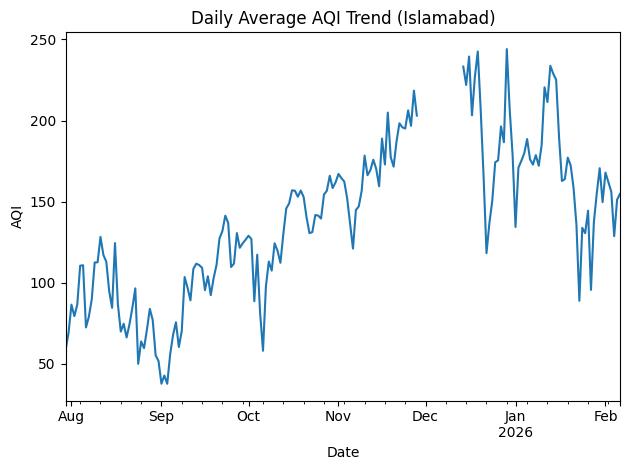

In [7]:
dff = df.set_index("timestamp_utc").sort_index()

daily = dff["aqi"].resample("D").mean()

plt.figure()
daily.plot()
plt.title("Daily Average AQI Trend (Islamabad)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.tight_layout()
plt.savefig(OUT / "daily_aqi_trend.png", dpi=200)
plt.show()


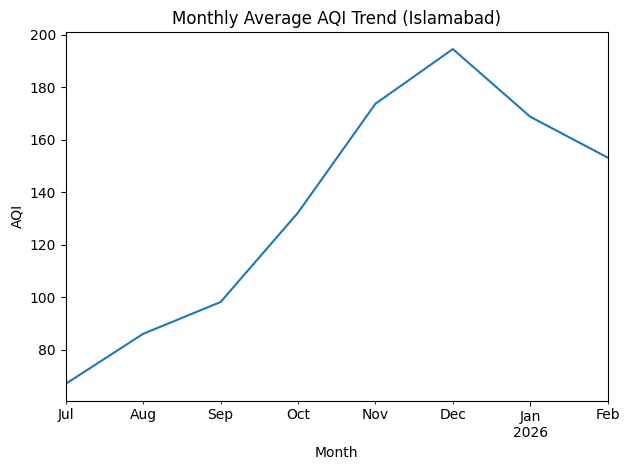

In [8]:
monthly = dff["aqi"].resample("M").mean()

plt.figure()
monthly.plot()
plt.title("Monthly Average AQI Trend (Islamabad)")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.tight_layout()
plt.savefig(OUT / "monthly_aqi_trend.png", dpi=200)
plt.show()


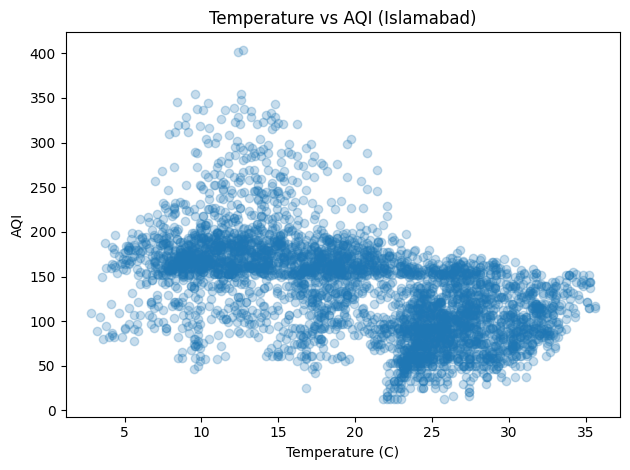

✅ Saved plots in outputs/:
 - outputs/daily_aqi_trend.png
 - outputs/monthly_aqi_trend.png
 - outputs/temp_vs_aqi.png


In [9]:
plt.figure()
plt.scatter(dff["temp_c"], dff["aqi"], alpha=0.25)
plt.title("Temperature vs AQI (Islamabad)")
plt.xlabel("Temperature (C)")
plt.ylabel("AQI")
plt.tight_layout()
plt.savefig(OUT / "temp_vs_aqi.png", dpi=200)
plt.show()

print("✅ Saved plots in outputs/:")
print(" - outputs/daily_aqi_trend.png")
print(" - outputs/monthly_aqi_trend.png")
print(" - outputs/temp_vs_aqi.png")


In [10]:
df_fe = df.copy().sort_values("timestamp_utc")

df_fe["aqi_lag1"] = df_fe["aqi"].shift(1)
df_fe["aqi_lag2"] = df_fe["aqi"].shift(2)
df_fe["aqi_lag24"] = df_fe["aqi"].shift(24)

df_fe["aqi_roll24"] = df_fe["aqi"].rolling(24).mean()
df_fe["aqi_roll7d"] = df_fe["aqi"].rolling(24*7).mean()

df_fe["aqi_diff1"] = df_fe["aqi_lag1"] - df_fe["aqi_lag2"]

df_fe[["timestamp_utc","aqi","aqi_lag1","aqi_lag2","aqi_lag24","aqi_roll24","aqi_roll7d","aqi_diff1"]].head(50)


,timestamp_utc,aqi,aqi_lag1,aqi_lag2,aqi_lag24,aqi_roll24,aqi_roll7d,aqi_diff1
78,2025-07-30 18:00:00+00:00,65.51,NaN,NaN,NaN,NaN,NaN,NaN
66,2025-07-30 19:00:00+00:00,65.51,65.51,NaN,NaN,NaN,NaN,NaN
152,2025-07-30 20:00:00+00:00,57.10,65.51,65.51,NaN,NaN,NaN,0.00
265,2025-07-30 21:00:00+00:00,61.30,57.10,65.51,NaN,NaN,NaN,-8.41
134,2025-07-30 22:00:00+00:00,45.83,61.30,57.10,NaN,NaN,NaN,4.20
1,2025-07-30 23:00:00+00:00,57.10,45.83,61.30,NaN,NaN,NaN,-15.47
232,2025-07-31 00:00:00+00:00,37.50,57.10,45.83,NaN,NaN,NaN,11.27
320,2025-07-31 01:00:00+00:00,50.00,37.50,57.10,NaN,NaN,NaN,-19.60
71,2025-07-31 02:00:00+00:00,73.92,50.00,37.50,NaN,NaN,NaN,12.50
465,2025-07-31 03:00:00+00:00,65.51,73.92,50.00,NaN,NaN,NaN,23.92


In [11]:
def check_alert(aqi):
    try:
        aqi = float(aqi)
    except Exception:
        return "unknown"

    if aqi > 300:
        return "🚨 Severe Hazardous"
    elif aqi > 150:
        return "⚠️ Unhealthy"
    elif aqi > 100:
        return "😷 Moderate"
    else:
        return "😊 Good"

df_alert = df.copy()
df_alert["alert"] = df_alert["aqi"].apply(check_alert)
df_alert[["timestamp_utc","aqi","alert"]].tail(20)


,timestamp_utc,aqi,alert
4003,2026-02-05 12:00:00+00:00,158.0,⚠️ Unhealthy
4004,2026-02-05 13:00:00+00:00,132.0,😷 Moderate
4005,2026-02-05 15:00:00+00:00,112.0,😷 Moderate
4006,2026-02-05 17:00:00+00:00,157.0,⚠️ Unhealthy
4007,2026-02-05 18:00:00+00:00,175.0,⚠️ Unhealthy
4008,2026-02-05 20:00:00+00:00,199.0,⚠️ Unhealthy
4009,2026-02-05 21:00:00+00:00,215.0,⚠️ Unhealthy
4010,2026-02-05 22:00:00+00:00,179.0,⚠️ Unhealthy
4011,2026-02-06 01:00:00+00:00,170.0,⚠️ Unhealthy
4012,2026-02-06 02:00:00+00:00,159.0,⚠️ Unhealthy


In [12]:
eda_csv = OUT / "eda_cleaned.csv"
df_fe.to_csv(eda_csv, index=False)
print("✅ Saved:", eda_csv)


✅ Saved: outputs\eda_cleaned.csv
